In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

In [2]:
class LaticiferDataset(Dataset):
    def __init__(self, df, root_dir, image_size=(1024, 1024), augment=False):
        self.df = df
        self.root = root_dir
        self.augment = augment
        self.image_size = image_size

        self.transforms = A.Compose([
            A.Resize(*image_size),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.ElasticTransform(p=0.3),
            A.GaussianBlur(p=0.2),
            A.Normalize(),
            ToTensorV2()
        ]) if augment else A.Compose([
            A.Resize(*image_size),
            A.Normalize(),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        gray_path = os.path.join(self.root, row['gray_img_path'])
        enhanced_path = os.path.join(self.root, row['enhanced_img_path'])
        mask_path = os.path.join(self.root, row['mask_path'])

        image = np.array(Image.open(enhanced_path).convert("L"))
        mask = np.array(Image.open(mask_path).convert("L")) // 255

        augmented = self.transforms(image=image, mask=mask)
        return augmented['image'], augmented['mask'].unsqueeze(0).float()

In [3]:
# U-Net Model (Lightweight)
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()

        def conv_block(in_c, out_c, dropout=0.0):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                #nn.Dropout2d(p=dropout),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                #nn.Dropout2d(p=dropout)
            )

        self.enc1 = conv_block(in_channels, 64, dropout=0.1)
        self.enc2 = conv_block(64, 128, dropout=0.1)
        self.enc3 = conv_block(128, 256, dropout=0.2)
        self.enc4 = conv_block(256, 512, dropout=0.2)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = conv_block(512, 1024, dropout=0.3)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512, dropout=0.2)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256, dropout=0.2)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128, dropout=0.1)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64, dropout=0.1)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return torch.sigmoid(self.final(d1))


In [4]:
# Dice Loss
def dice_loss(pred, target, smooth=1.):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

In [5]:
def compute_dice(preds, targets, threshold=0.5, eps=1e-7):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

In [6]:
def train_model(model, train_loader, test_loader, num_epochs=20, save_dir=None, log_interval=5, accumulation_steps=4):
    model = model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
    criterion = lambda pred, target: nn.BCELoss()(pred, target) + dice_loss(pred, target)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, min_lr=1e-6)

    best_dice = 0.0
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_path = None
    patience = 75
    counter = 0

    for epoch in tqdm(range(1, num_epochs + 1), desc="Training Epochs", leave=False, unit='epoch'):
        model.train()
        train_loss = 0
        optimizer.zero_grad()

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)
            loss = criterion(preds, masks)
            loss = loss / accumulation_steps  # scale loss for accumulation

            loss.backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()

            train_loss += loss.item() * accumulation_steps  # scale back for reporting

        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        dice_scores = []

        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.cuda(), masks.cuda()
                preds = model(images)
                loss = criterion(preds, masks)
                val_loss += loss.item()

                dice = compute_dice(preds, masks)
                dice_scores.append(dice)

        avg_val_loss = val_loss / len(test_loader)
        avg_dice = np.mean(dice_scores)
        scheduler.step(avg_val_loss)

        if avg_dice > best_dice:
            best_dice = avg_dice
            best_epoch = epoch
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            counter = 0
            if best_model_path and os.path.exists(best_model_path):
                os.remove(best_model_path)
            if save_dir:
                os.makedirs(save_dir, exist_ok=True)
                best_model_path = os.path.join(save_dir, f"best_unet1024x1024_reg2_{epoch}_{best_dice:.4f}.pth")
                torch.save(model.state_dict(), best_model_path)
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                return best_model_path, best_dice, best_val_loss

        if epoch % log_interval == 0 or epoch == num_epochs:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f} | "
                  f"Best Dice: {best_dice:.4f} | LR: {current_lr:.6f}")

    print("Training completed.")
    print(f"Best Dice achieved: {best_dice}, Epoch: {best_epoch}")
    if best_model_path:
        print("Best model path:", best_model_path)

    return best_model_path, best_dice, best_val_loss


In [7]:
dataset_root = "/home/smadper/TFM/datasets/laticifers"
df = pd.read_csv(os.path.join(dataset_root, "laticifer_dataset_index.csv"))
df = df[df["is_labeled"] == True].reset_index(drop=True)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)

train_dataset = LaticiferDataset(train_df, dataset_root, augment=True)
test_dataset = LaticiferDataset(val_df, dataset_root, augment=False)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

Total samples: 35
Training samples: 31
Test samples: 4


In [8]:
model = UNet(in_channels=1).cuda()

best_model_path, best_dice, best_val_loss = train_model(
    model=model, 
    train_loader=train_loader, 
    test_loader=test_loader, 
    num_epochs=300,
    save_dir="saved_models/"
)

Training Epochs:   2%|▏         | 5/300 [02:01<1:58:46, 24.16s/epoch]

Epoch 005 | Train Loss: 1.1065 | Val Loss: 1.0609 | Best Dice: 0.0000 | LR: 0.001000


Training Epochs:   3%|▎         | 10/300 [04:04<1:59:02, 24.63s/epoch]

Epoch 010 | Train Loss: 1.0559 | Val Loss: 1.0433 | Best Dice: 0.0000 | LR: 0.001000


Training Epochs:   5%|▌         | 15/300 [06:04<1:55:39, 24.35s/epoch]

Epoch 015 | Train Loss: 1.0381 | Val Loss: 0.9897 | Best Dice: 0.0000 | LR: 0.001000


Training Epochs:   7%|▋         | 20/300 [08:02<1:51:37, 23.92s/epoch]

Epoch 020 | Train Loss: 0.9996 | Val Loss: 0.9878 | Best Dice: 0.0006 | LR: 0.001000


Training Epochs:   8%|▊         | 25/300 [10:02<1:49:46, 23.95s/epoch]

Epoch 025 | Train Loss: 1.0018 | Val Loss: 0.9833 | Best Dice: 0.2641 | LR: 0.001000


Training Epochs:  10%|█         | 30/300 [12:07<1:52:39, 25.04s/epoch]

Epoch 030 | Train Loss: 0.9862 | Val Loss: 0.9621 | Best Dice: 0.2824 | LR: 0.001000


Training Epochs:  12%|█▏        | 35/300 [14:09<1:48:49, 24.64s/epoch]

Epoch 035 | Train Loss: 0.9675 | Val Loss: 0.9341 | Best Dice: 0.2957 | LR: 0.001000


Training Epochs:  13%|█▎        | 40/300 [16:13<1:47:45, 24.87s/epoch]

Epoch 040 | Train Loss: 0.9508 | Val Loss: 0.9215 | Best Dice: 0.3003 | LR: 0.001000


Training Epochs:  15%|█▌        | 45/300 [18:14<1:42:28, 24.11s/epoch]

Epoch 045 | Train Loss: 0.9608 | Val Loss: 0.9373 | Best Dice: 0.3016 | LR: 0.001000


Training Epochs:  17%|█▋        | 50/300 [20:13<1:39:19, 23.84s/epoch]

Epoch 050 | Train Loss: 0.9679 | Val Loss: 0.9392 | Best Dice: 0.3016 | LR: 0.001000


Training Epochs:  18%|█▊        | 55/300 [22:15<1:39:34, 24.39s/epoch]

Epoch 055 | Train Loss: 0.9423 | Val Loss: 0.9059 | Best Dice: 0.3016 | LR: 0.001000


Training Epochs:  20%|██        | 60/300 [24:15<1:35:56, 23.98s/epoch]

Epoch 060 | Train Loss: 0.9501 | Val Loss: 0.9158 | Best Dice: 0.3168 | LR: 0.001000


Training Epochs:  22%|██▏       | 65/300 [26:18<1:35:28, 24.38s/epoch]

Epoch 065 | Train Loss: 0.9147 | Val Loss: 0.8961 | Best Dice: 0.3237 | LR: 0.001000


Training Epochs:  23%|██▎       | 70/300 [28:19<1:33:48, 24.47s/epoch]

Epoch 070 | Train Loss: 0.9123 | Val Loss: 0.8762 | Best Dice: 0.3369 | LR: 0.001000


Training Epochs:  25%|██▌       | 75/300 [30:20<1:31:23, 24.37s/epoch]

Epoch 075 | Train Loss: 0.8883 | Val Loss: 0.9022 | Best Dice: 0.3415 | LR: 0.001000


Training Epochs:  27%|██▋       | 80/300 [32:19<1:28:48, 24.22s/epoch]

Epoch 080 | Train Loss: 0.8786 | Val Loss: 0.8580 | Best Dice: 0.3482 | LR: 0.001000


Training Epochs:  28%|██▊       | 85/300 [34:20<1:26:43, 24.20s/epoch]

Epoch 085 | Train Loss: 0.8775 | Val Loss: 0.8484 | Best Dice: 0.3567 | LR: 0.001000


Training Epochs:  30%|███       | 90/300 [36:19<1:24:04, 24.02s/epoch]

Epoch 090 | Train Loss: 0.8675 | Val Loss: 0.8550 | Best Dice: 0.3649 | LR: 0.001000


Training Epochs:  32%|███▏      | 95/300 [38:18<1:20:49, 23.66s/epoch]

Epoch 095 | Train Loss: 0.8454 | Val Loss: 0.8226 | Best Dice: 0.3782 | LR: 0.001000


Training Epochs:  33%|███▎      | 100/300 [40:19<1:20:00, 24.00s/epoch]

Epoch 100 | Train Loss: 0.8422 | Val Loss: 0.8109 | Best Dice: 0.3893 | LR: 0.001000


Training Epochs:  35%|███▌      | 105/300 [42:24<1:20:49, 24.87s/epoch]

Epoch 105 | Train Loss: 0.8441 | Val Loss: 0.8230 | Best Dice: 0.3893 | LR: 0.001000


Training Epochs:  37%|███▋      | 110/300 [44:27<1:17:47, 24.57s/epoch]

Epoch 110 | Train Loss: 0.8228 | Val Loss: 0.8046 | Best Dice: 0.3954 | LR: 0.001000


Training Epochs:  38%|███▊      | 115/300 [46:31<1:15:41, 24.55s/epoch]

Epoch 115 | Train Loss: 0.8084 | Val Loss: 0.7910 | Best Dice: 0.4084 | LR: 0.001000


Training Epochs:  40%|████      | 120/300 [48:31<1:11:55, 23.97s/epoch]

Epoch 120 | Train Loss: 0.7960 | Val Loss: 0.7820 | Best Dice: 0.4145 | LR: 0.001000


Training Epochs:  42%|████▏     | 125/300 [50:33<1:10:22, 24.13s/epoch]

Epoch 125 | Train Loss: 0.7901 | Val Loss: 0.7762 | Best Dice: 0.4223 | LR: 0.001000


Training Epochs:  43%|████▎     | 130/300 [52:35<1:09:28, 24.52s/epoch]

Epoch 130 | Train Loss: 0.7918 | Val Loss: 0.7866 | Best Dice: 0.4246 | LR: 0.001000


Training Epochs:  45%|████▌     | 135/300 [54:37<1:06:49, 24.30s/epoch]

Epoch 135 | Train Loss: 0.7797 | Val Loss: 0.7600 | Best Dice: 0.4293 | LR: 0.001000


Training Epochs:  47%|████▋     | 140/300 [56:39<1:04:55, 24.35s/epoch]

Epoch 140 | Train Loss: 0.7635 | Val Loss: 0.7563 | Best Dice: 0.4313 | LR: 0.001000


Training Epochs:  48%|████▊     | 145/300 [58:42<1:04:09, 24.84s/epoch]

Epoch 145 | Train Loss: 0.7863 | Val Loss: 0.7807 | Best Dice: 0.4381 | LR: 0.001000


Training Epochs:  50%|█████     | 150/300 [1:00:45<1:01:06, 24.45s/epoch]

Epoch 150 | Train Loss: 0.7574 | Val Loss: 0.7565 | Best Dice: 0.4436 | LR: 0.001000


Training Epochs:  52%|█████▏    | 155/300 [1:02:45<57:56, 23.97s/epoch]  

Epoch 155 | Train Loss: 0.7591 | Val Loss: 0.7488 | Best Dice: 0.4436 | LR: 0.001000


Training Epochs:  53%|█████▎    | 160/300 [1:04:50<57:49, 24.78s/epoch]

Epoch 160 | Train Loss: 0.7646 | Val Loss: 0.7506 | Best Dice: 0.4455 | LR: 0.001000


Training Epochs:  55%|█████▌    | 165/300 [1:06:53<55:30, 24.67s/epoch]

Epoch 165 | Train Loss: 0.7552 | Val Loss: 0.7374 | Best Dice: 0.4473 | LR: 0.001000


Training Epochs:  57%|█████▋    | 170/300 [1:08:53<51:46, 23.90s/epoch]

Epoch 170 | Train Loss: 0.7570 | Val Loss: 0.7311 | Best Dice: 0.4513 | LR: 0.001000


Training Epochs:  58%|█████▊    | 175/300 [1:10:55<50:38, 24.31s/epoch]

Epoch 175 | Train Loss: 0.7506 | Val Loss: 0.7420 | Best Dice: 0.4513 | LR: 0.001000


Training Epochs:  60%|██████    | 180/300 [1:12:54<47:42, 23.85s/epoch]

Epoch 180 | Train Loss: 0.7402 | Val Loss: 0.7319 | Best Dice: 0.4539 | LR: 0.001000


Training Epochs:  62%|██████▏   | 185/300 [1:15:00<47:31, 24.80s/epoch]

Epoch 185 | Train Loss: 0.7317 | Val Loss: 0.7237 | Best Dice: 0.4582 | LR: 0.000500


Training Epochs:  63%|██████▎   | 190/300 [1:17:02<44:32, 24.29s/epoch]

Epoch 190 | Train Loss: 0.7312 | Val Loss: 0.7264 | Best Dice: 0.4583 | LR: 0.000500


Training Epochs:  65%|██████▌   | 195/300 [1:19:03<42:29, 24.28s/epoch]

Epoch 195 | Train Loss: 0.7330 | Val Loss: 0.7268 | Best Dice: 0.4598 | LR: 0.000500


Training Epochs:  67%|██████▋   | 200/300 [1:21:05<40:43, 24.44s/epoch]

Epoch 200 | Train Loss: 0.7280 | Val Loss: 0.7213 | Best Dice: 0.4603 | LR: 0.000500


Training Epochs:  68%|██████▊   | 205/300 [1:23:10<39:10, 24.75s/epoch]

Epoch 205 | Train Loss: 0.7252 | Val Loss: 0.7260 | Best Dice: 0.4603 | LR: 0.000500


Training Epochs:  70%|███████   | 210/300 [1:25:12<36:22, 24.25s/epoch]

Epoch 210 | Train Loss: 0.7180 | Val Loss: 0.7420 | Best Dice: 0.4603 | LR: 0.000500


Training Epochs:  72%|███████▏  | 215/300 [1:27:12<33:56, 23.96s/epoch]

Epoch 215 | Train Loss: 0.7103 | Val Loss: 0.7262 | Best Dice: 0.4603 | LR: 0.000500


Training Epochs:  73%|███████▎  | 220/300 [1:29:16<32:29, 24.37s/epoch]

Epoch 220 | Train Loss: 0.7227 | Val Loss: 0.7285 | Best Dice: 0.4603 | LR: 0.000500


Training Epochs:  75%|███████▌  | 225/300 [1:31:14<29:29, 23.59s/epoch]

Epoch 225 | Train Loss: 0.7112 | Val Loss: 0.7299 | Best Dice: 0.4607 | LR: 0.000500


Training Epochs:  77%|███████▋  | 230/300 [1:33:16<28:10, 24.15s/epoch]

Epoch 230 | Train Loss: 0.7058 | Val Loss: 0.7232 | Best Dice: 0.4607 | LR: 0.000250


Training Epochs:  78%|███████▊  | 235/300 [1:35:16<26:09, 24.14s/epoch]

Epoch 235 | Train Loss: 0.6979 | Val Loss: 0.7244 | Best Dice: 0.4607 | LR: 0.000250


Training Epochs:  80%|████████  | 240/300 [1:37:17<24:13, 24.23s/epoch]

Epoch 240 | Train Loss: 0.7172 | Val Loss: 0.7205 | Best Dice: 0.4607 | LR: 0.000250


Training Epochs:  82%|████████▏ | 245/300 [1:39:19<22:19, 24.35s/epoch]

Epoch 245 | Train Loss: 0.6961 | Val Loss: 0.7191 | Best Dice: 0.4607 | LR: 0.000250


Training Epochs:  83%|████████▎ | 250/300 [1:41:22<20:28, 24.56s/epoch]

Epoch 250 | Train Loss: 0.6986 | Val Loss: 0.7175 | Best Dice: 0.4608 | LR: 0.000125


Training Epochs:  85%|████████▌ | 255/300 [1:43:22<17:55, 23.89s/epoch]

Epoch 255 | Train Loss: 0.6925 | Val Loss: 0.7207 | Best Dice: 0.4608 | LR: 0.000125


Training Epochs:  87%|████████▋ | 260/300 [1:45:23<16:08, 24.21s/epoch]

Epoch 260 | Train Loss: 0.6985 | Val Loss: 0.7192 | Best Dice: 0.4608 | LR: 0.000063


Training Epochs:  88%|████████▊ | 265/300 [1:47:23<14:07, 24.22s/epoch]

Epoch 265 | Train Loss: 0.6981 | Val Loss: 0.7227 | Best Dice: 0.4608 | LR: 0.000063


Training Epochs:  90%|█████████ | 270/300 [1:49:25<12:07, 24.24s/epoch]

Epoch 270 | Train Loss: 0.6856 | Val Loss: 0.7210 | Best Dice: 0.4608 | LR: 0.000031


Training Epochs:  92%|█████████▏| 275/300 [1:51:26<09:57, 23.92s/epoch]

Epoch 275 | Train Loss: 0.6939 | Val Loss: 0.7203 | Best Dice: 0.4608 | LR: 0.000031


Training Epochs:  93%|█████████▎| 280/300 [1:53:26<08:03, 24.17s/epoch]

Epoch 280 | Train Loss: 0.6844 | Val Loss: 0.7209 | Best Dice: 0.4608 | LR: 0.000016


Training Epochs:  95%|█████████▌| 285/300 [1:55:27<06:04, 24.32s/epoch]

Epoch 285 | Train Loss: 0.6895 | Val Loss: 0.7194 | Best Dice: 0.4608 | LR: 0.000016


Training Epochs:  97%|█████████▋| 290/300 [1:57:28<04:01, 24.17s/epoch]

Epoch 290 | Train Loss: 0.6820 | Val Loss: 0.7204 | Best Dice: 0.4608 | LR: 0.000016


Training Epochs:  98%|█████████▊| 295/300 [1:59:28<01:59, 23.82s/epoch]

Epoch 295 | Train Loss: 0.6818 | Val Loss: 0.7198 | Best Dice: 0.4608 | LR: 0.000008


Epoch 300 | Train Loss: 0.6912 | Val Loss: 0.7205 | Best Dice: 0.4608 | LR: 0.000008
Training completed.
Best Dice achieved: 0.46080946922302246, Epoch: 248
Best model path: saved_models/best_unet1024x1024_reg2_236_0.4607.pth


In [9]:
def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    model.cuda()

    samples_shown = 0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.cuda(), masks.cuda()
            preds = model(images)

            for i in range(images.size(0)):
                if samples_shown >= num_samples:
                    return

                pred = preds[i].unsqueeze(0)
                target = masks[i].unsqueeze(0)
                dice = compute_dice(pred, target)

                image_np = images[i].cpu().squeeze().numpy()
                mask_np = masks[i].cpu().squeeze().numpy()
                pred_np = (pred > 0.5).float().cpu().squeeze().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(image_np, cmap='gray')
                axs[0].set_title("Input Image")
                axs[1].imshow(mask_np, cmap='gray')
                axs[1].set_title("Ground Truth")
                axs[2].imshow(pred_np, cmap='gray')
                axs[2].set_title(f"Predicted (Dice: {dice:.4f})")

                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()

                samples_shown += 1

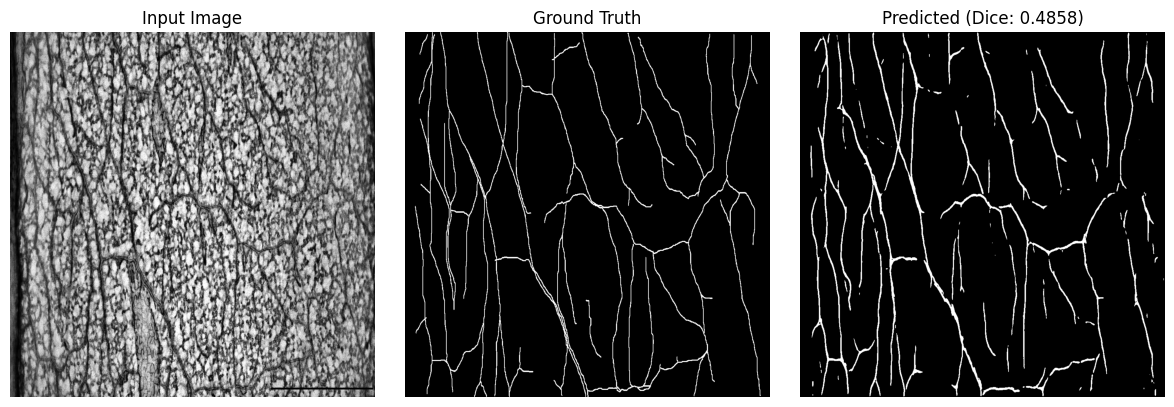

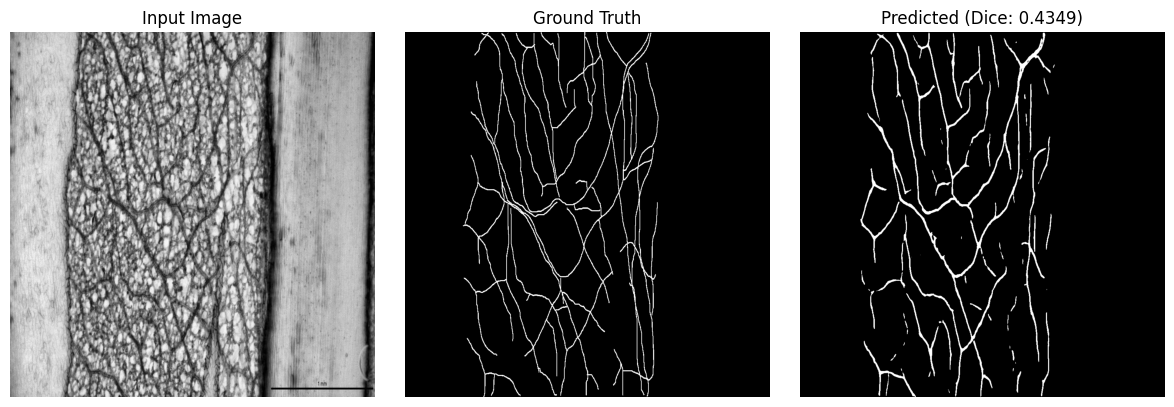

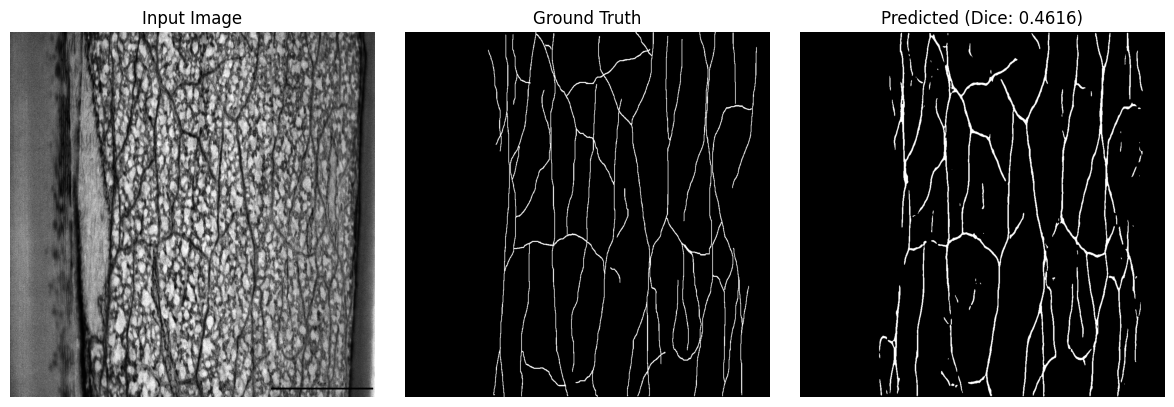

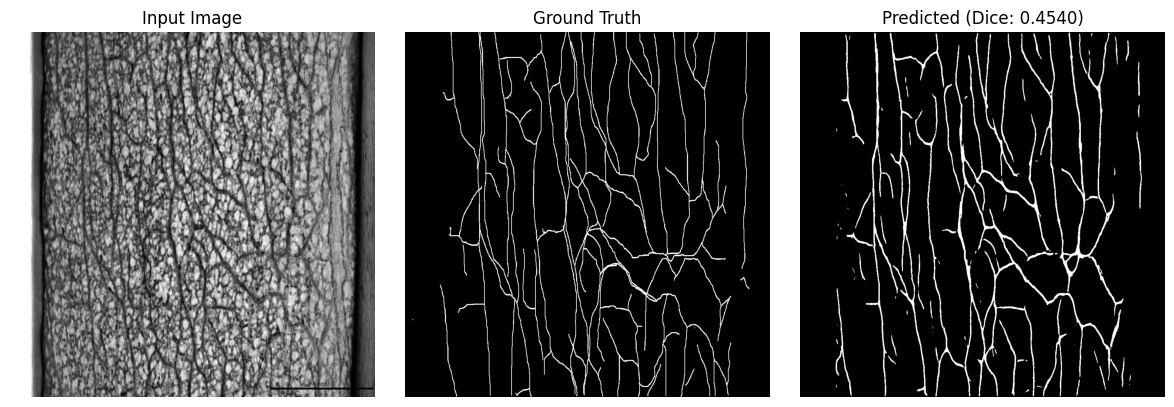

In [10]:
model.load_state_dict(torch.load(best_model_path))

visualize_predictions(model, test_loader, num_samples=4)